In [2]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from tqdm import tqdm
import cvxpy as cp

Text(0, 0.5, 'Y')

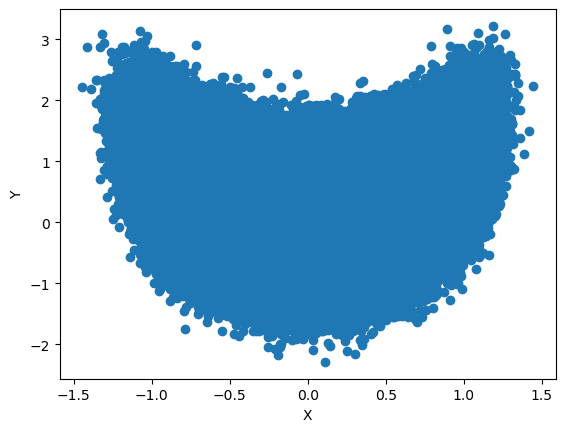

In [4]:
n = 100
m = 10
a = 5

with open('../databases/first_database.pkl', 'rb') as f:
  X,Y = pkl.load(f)

plt.plot(X,Y,'o')
plt.xlabel("X")
plt.ylabel("Y")


In [ ]:
print(X.size)